# House Rent Prediction - Linear Regression

## Imports

In [2]:
# Utilities
import numpy as np
import pandas as pd
import math
import tensorflow as tf

# Matplotlib
import matplotlib.pyplot as plt

# Seaborn
import seaborn as sns

# Scipy
from scipy.stats import boxcox

# SKLearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dataset
import kagglehub
path = kagglehub.dataset_download("iamsouravbanerjee/house-rent-prediction-dataset")
dataset = pd.read_csv(f"{path}\\House_Rent_Dataset.csv")

# Definição da Seed
seed = 42

c:\Users\gusta\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pré Processamento

In [3]:
# Based on this analysis we can confirm there's some columns that are not interesting for our algorithm (explain why?)
# Such as: Posted On, Floor, Area Locality, City, Tenant Preferred e Point of Contact

# We can remove those columns for prevent our dataset to have many...

dataset = dataset.drop(['Posted On', 'Floor', 'Area Locality'], axis=1)
dataset.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner


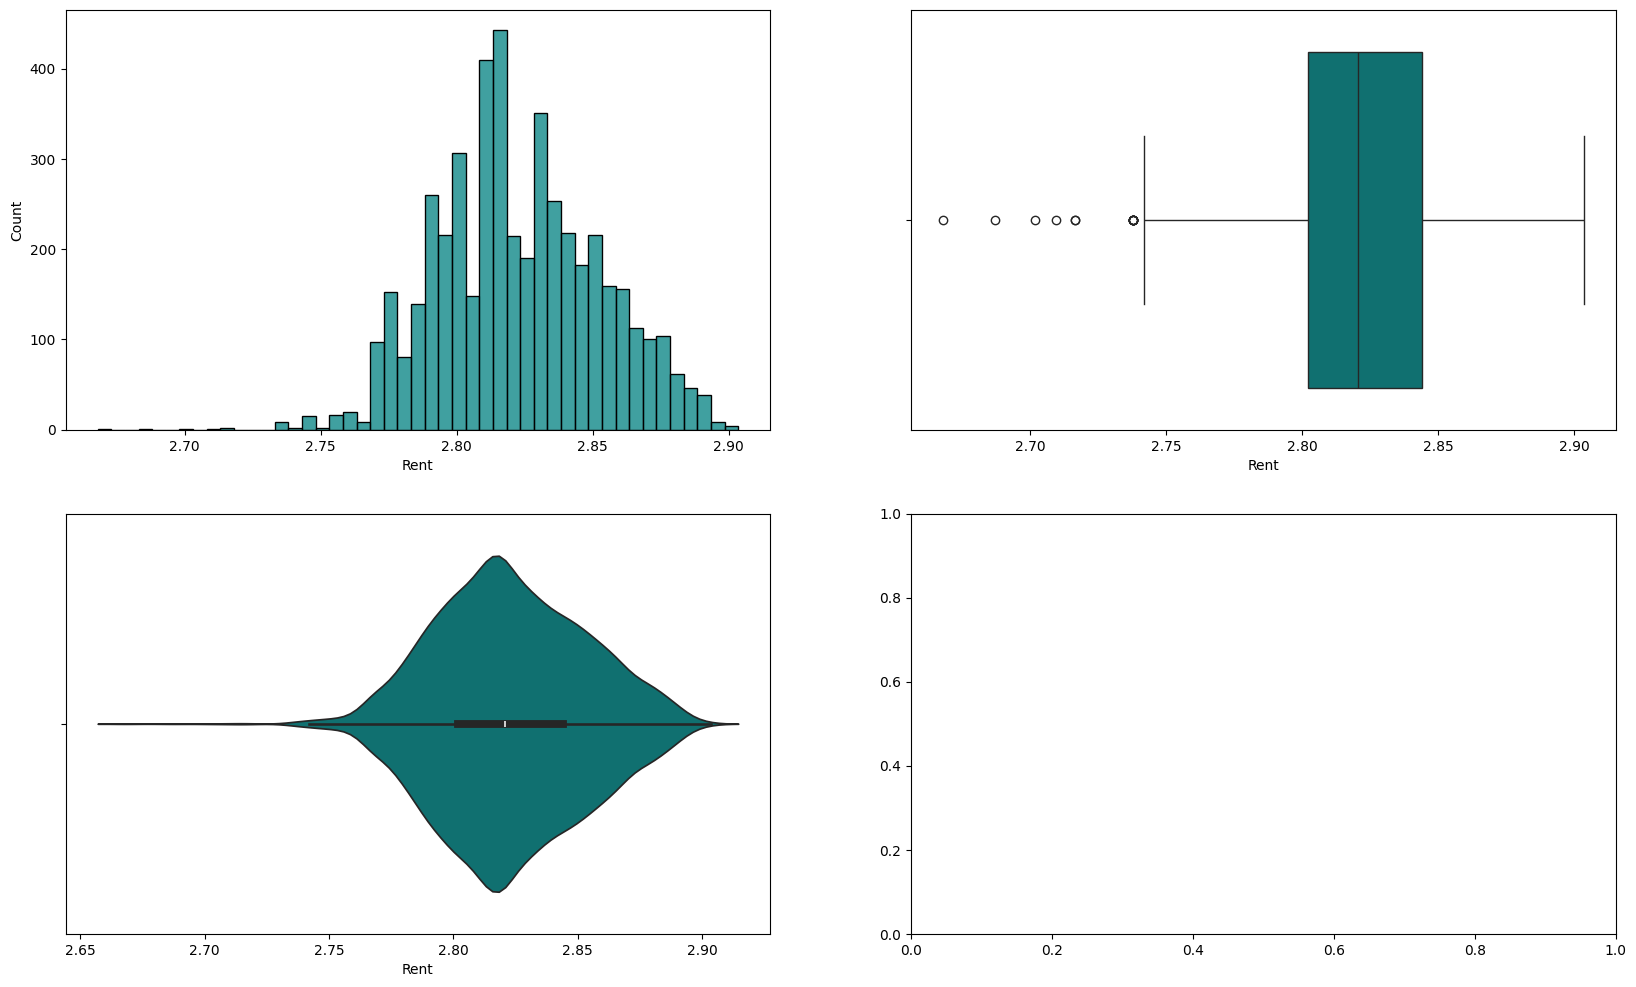

In [4]:
"""
Percebemos que essa coluna tem outliers que precisam ser trabalhados.
Além disso, a distribuição dos dados não está tão agradável para regressão, como a obliquidade e curtose.
Muita variância pode tornar mais difícil de encontrar padrões nos dados.

Primeiro vamos remover os outliers
"""

"""
Para isso vamos utilizar a Box Cox
A Box Cox é uma técnica de normalização para normalizar variáveis 
idependentes que não são normalmente  distribuídas. 
"""

# Remoção dos outliers
max_rent = dataset['Rent'].max()
index_max_rent = dataset[dataset['Rent'] == max_rent].index
dataset = dataset.drop(index_max_rent)

# Box Cox
dataset['Rent'] = boxcox(dataset['Rent'])[0]

# Resultados da aplicação das técnicas
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = dataset['Rent'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = dataset['Rent'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = dataset['Rent'], ax= ax[1, 0], color= 'teal')

plt.show()

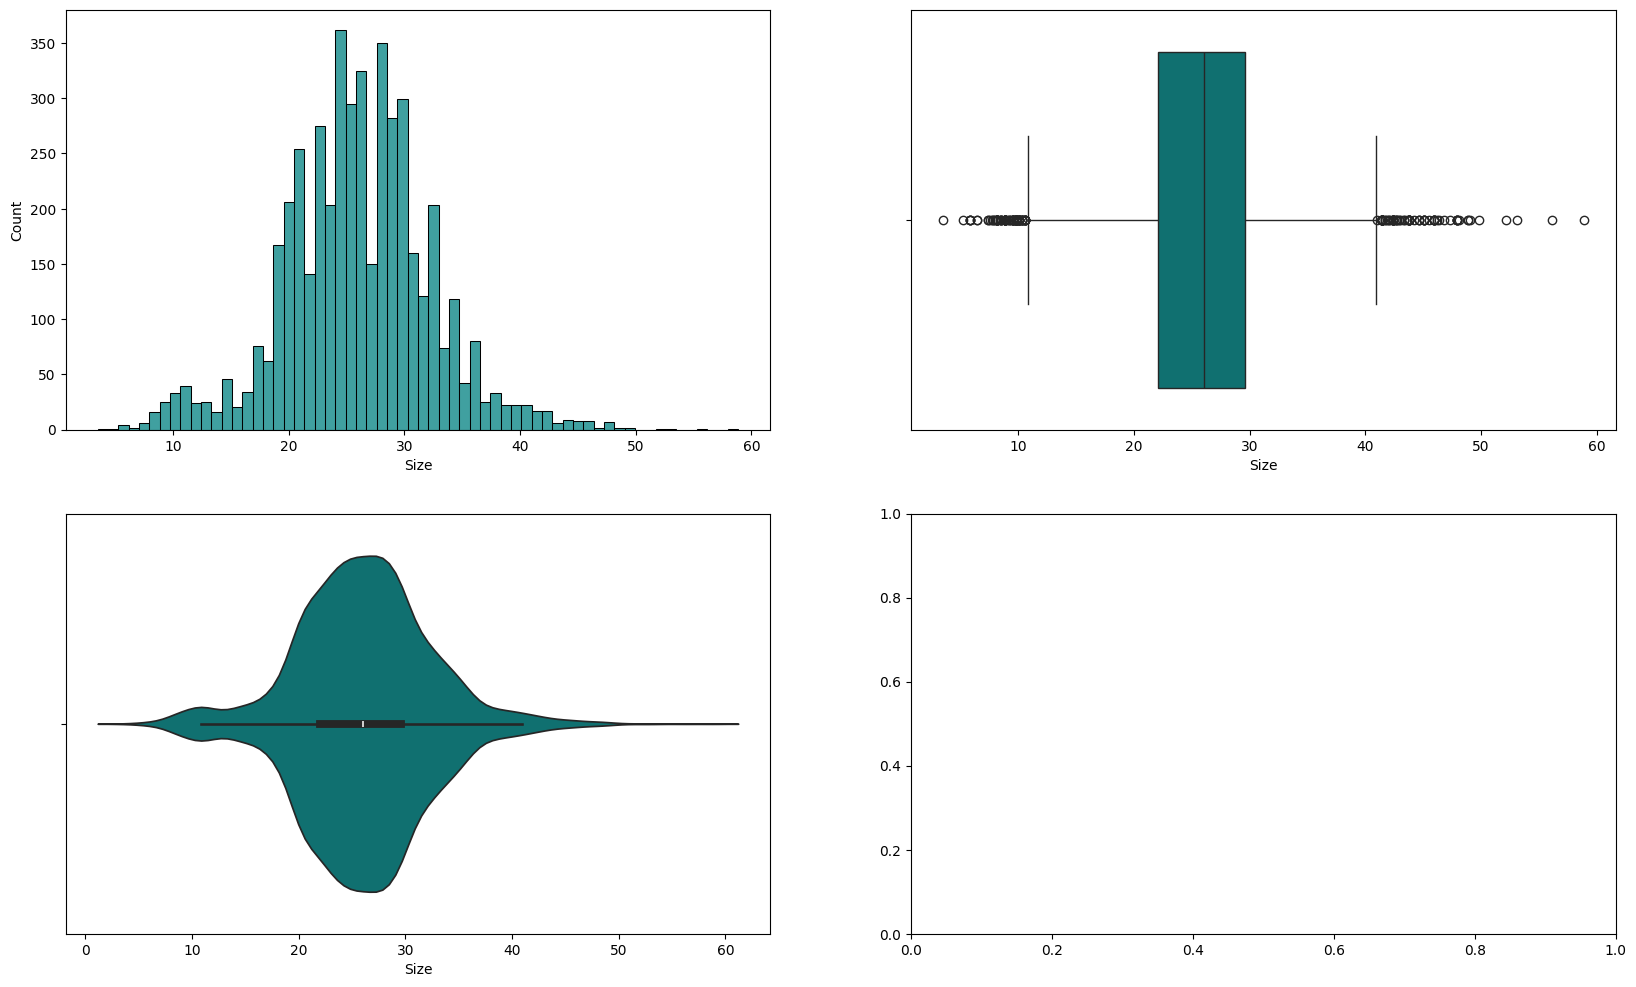

In [5]:
dataset['Size'] = boxcox(dataset['Size'])[0]

# Resultados
ig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = dataset['Size'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = dataset['Size'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = dataset['Size'], ax= ax[1, 0], color= 'teal')
plt.show()

In [6]:
# Normalização das colunas
dataset = dataset.drop_duplicates()

def one_hot_encode(data, column):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded)
    return data

columns = ['Area Type', 'Furnishing Status',  'City', 'Tenant Preferred', 'Point of Contact']
for col in columns:
    dataset = one_hot_encode(dataset, col)

for col in dataset.columns:
    if dataset[col].dtype == 'bool':
        dataset[col] = dataset[col].astype(int)

dataset.head()

,BHK,Rent,Size,Bathroom,Carpet Area,Super Area,Semi-Furnished,Unfurnished,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Bachelors/Family,Family,Contact Builder,Contact Owner
0,2,2.802011,28.637808,2,0,1,0,1,0,0,0,1,0,1,0,0,1
1,2,2.828578,25.411054,1,0,1,1,0,0,0,0,1,0,1,0,0,1
2,2,2.822901,27.635364,1,0,1,1,0,0,0,0,1,0,1,0,0,1
3,2,2.802011,25.411054,1,0,1,0,1,0,0,0,1,0,1,0,0,1
4,2,2.789000,25.998849,1,1,0,0,1,0,0,0,1,0,0,0,0,1


In [7]:
# Separação dos Dados entre Treino e Teste
X = dataset.drop('Rent', axis= 1)
y = dataset['Rent']

boxcox_result = boxcox(y)
y_boxcox = boxcox_result[0]

X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size= 0.2, random_state = seed)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train.shape

(3588, 16)

In [8]:
# Treinando Modelo
tf.random.set_seed(seed)

lnrg_model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
lnrg_model.compile(loss=tf.keras.losses.mae,
           optimizer=tf.keras.optimizers.Adam(),
           metrics=["mae"])

lnrg_model_history=lnrg_model.fit(X_train, y_train, epochs=100)
lnrg_pred=lnrg_model.predict(X_test)

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3370 - mae: 0.3370
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0480 - mae: 0.0480
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0387 - mae: 0.0387
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0333 - mae: 0.0333
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0293 - mae: 0.0293
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0253 - mae: 0.0253
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266 - mae: 0.0266
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - mae: 0.0227
Epoch 9/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - mae: 0.0240
Epoch 10/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212 - mae: 0.0212
Epoch 11/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226 - mae: 0.0226
Epoch 12/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 - mae: 0.0218
Epoch 13/100


RMSE: 0.0207
MAE: 0.0154
R2: 0.3508
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - mae: 0.0154  


[0.01541141327470541, 0.01541141327470541]

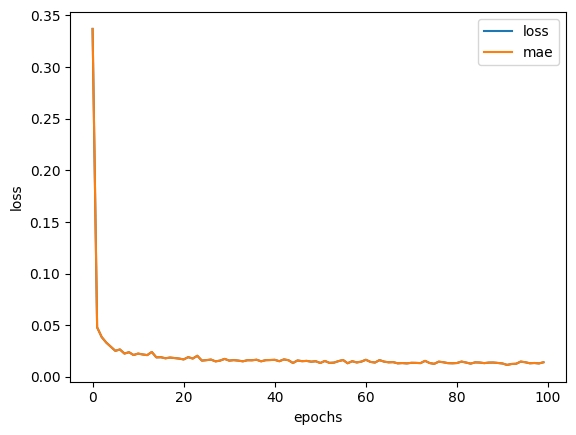

In [9]:
#  Avalicação do Modelo
y_true = list(y_test)
y_pred = lnrg_pred.flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

# Plot epochs
pd.DataFrame(lnrg_model_history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

lnrg_model.evaluate(X_test, y_test)